In [1]:
%env PATH=/usr/local/cuda-11.5/bin:$PATH

env: PATH=/usr/local/cuda-11.5/bin:$PATH


In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

In [232]:
from pinns.prelude import *
from pinns.domain import Sphere
from scipy.stats.qmc import Sobol
import matplotlib.pyplot as plt

In [603]:
domain = Sphere(1., (0., 0., 0.))
x_dom = array(Sobol(3, seed=0).random_base2(8))
x_dom = domain.transform(x_dom)
x_bnd = array(Sobol(2, seed=1).random_base2(6))
x_bnd = domain.transform_bnd(x_bnd)


In [604]:
def mag(x):
    return array([0., 0., 1.])


def phi2_solution(x, x_bnd):
    eps = 1e-7
    def g(y):
        n = y / norm(y, axis=-1)
        return dot(mag(y), n)
    
    dist = vmap(lambda x: norm(x - x_bnd, axis=-1))(x)
    _g = vmap(g)(x_bnd)
    def kernel(dist):
        idx = dist > eps
        newton_kernel = where(idx, 1 / dist, 0.)
        N = jnp.count_nonzero(idx)
        return (4 * pi * 1. ** 2) / (4 * pi * N) * dot(newton_kernel, _g)

    return vmap(kernel)(dist)

In [605]:
_x_bnd = array(Sobol(2, seed=123).random_base2(15))
_x_bnd = domain.transform_bnd(_x_bnd)
phi_bnd = phi2_solution(x_bnd, _x_bnd)

In [606]:
from dataclasses import dataclass, field
from jaxopt.linear_solve import solve_cg


def rbf(x, y, gamma=1.):
    d = jnp.sum((x - y) ** 2, axis=-1)
    return exp(-gamma * d)


@partial(jit, static_argnames=('k', 'vectorized'))
def pairwise_kernel(k, x, y, vectorized=False, *args, **kwargs):
    if vectorized:
        def _k1(x):
            return k(x, y, *args, **kwargs)
        return vmap(_k1)(x)
    else:
        def _k2(x, y):
            return k(x, y, *args, **kwargs)
        return vmap(vmap(_k2, (None, 0)), (0, None))(x, y)


@dataclass(frozen=True)
class KRR:
    coef: ndarray
    support: ndarray
    kernel: Callable = field(compare=False)

    def __call__(self, x):
        K = self.kernel(x, self.support)
        return K @ self.coef


def krr(x, y, kernel, alpha, solver_kwargs=None, *args, **kwargs) -> KRR:
    @wraps(kernel)
    def _kernel(x, y):
        return pairwise_kernel(kernel, x, y, *args, **kwargs)
    K = _kernel(x, x)

    def matvec(x):
        return K @ x
    if solver_kwargs is None:
        kw = {}
    else:
        kw = solver_kwargs
    coef = solve_cg(matvec, y, ridge=alpha, **kw)
    return KRR(coef, x, _kernel)



In [607]:
X = concatenate([x_bnd, x_dom])
gamma = 0.1

def compute_stiffness_matrix(kernel, data, support, *args, **kwargs):
    grad_rbf = grad(kernel)
    grad_rbf = pairwise_kernel(grad_rbf, data, support, *args, **kwargs)
    S = jnp.tensordot(grad_rbf, grad_rbf, ((0,2), (0,2)))
    return S / len(data)




In [608]:
alpha = 1.
Q = 2 / 3 * pi * compute_stiffness_matrix(rbf, X, X, gamma=gamma)
idx = jnp.diag_indices_from(Q)
Q = Q.at[idx].set(Q[idx] + alpha)
A = pairwise_kernel(rbf, x_bnd, X, gamma=gamma)
b = phi_bnd
c = zeros((len(X),))

In [609]:
from jaxopt import EqualityConstrainedQP
qp = EqualityConstrainedQP(
    tol=1e-3, 
    refine_regularization=2, 
    refine_maxiter=10, 
    maxiter=100, 
    jit=True
)

sol = qp.run(params_obj=(Q, c), params_eq=(A, b)).params
coef = sol.primal

In [610]:
def sol(x):
    return pairwise_kernel(rbf, x, X, gamma=gamma) @ coef

In [611]:
y_sol = sol(X)
y_analytic = X[:, 2] / 3
mean((y_analytic - y_sol) ** 2)

DeviceArray(2.0210293e-05, dtype=float32)

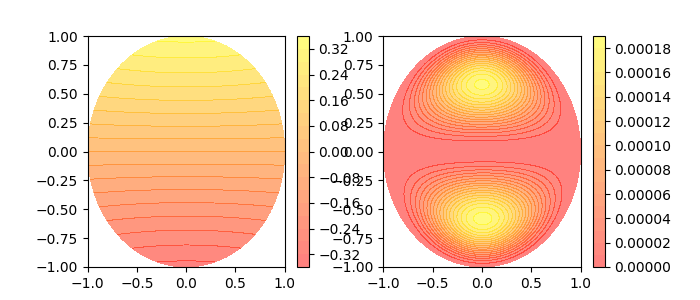

In [612]:
import itertools
import numpy as np

def plot_sol(sol, ax):
    plt.sca(ax)
    N = 1000
    x = np.linspace(-1, 1, N)
    z = np.linspace(-1, 1, N)
    X = np.array([_x for _x in itertools.product(x, z)])
    _X = jnp.asarray(X)
    _X = jnp.insert(_X, array([1]), zeros((N * N, 1)), 1)
    phi = np.array(sol(_X))
    phi[np.linalg.norm(X, axis=-1) > 1.] = np.nan

    p = ax.contourf(x, z, phi.reshape(N, N).T, 20, cmap=plt.get_cmap("autumn"), alpha=0.5)
    plt.colorbar(p)

fig = plt.figure(figsize=(7, 3))
ax1, ax2 = fig.subplots(1, 2)
plot_sol(lambda x: sol(x), ax1)
plot_sol(lambda x: (x[..., 2] / 3 - sol(x)) ** 2, ax2)

In [880]:
gamma = 1.
def l(x):
    return (1 - norm(x, axis=-1) ** 2)

def kernel_bnd(x, y):
    return rbf(x, y, gamma=gamma)

def kernel_dom(x, y):
    #return l(x) * rbf(x, y, gamma=gamma)
    return rbf(x, y, gamma=gamma)

def compute_stiffness_matrix(kernel, data, support, *args, **kwargs):
    grad_rbf = grad(kernel)
    grad_rbf = pairwise_kernel(grad_rbf, data, support, *args, **kwargs)
    S = jnp.tensordot(grad_rbf, grad_rbf, ((0,2), (0,2)))
    return S / len(data)


def compute_bnd_matrix(kernel, data, support, bnd, *args, **kwargs):
    grad_rbf = grad(kernel)
    grad_rbf_bnd = pairwise_kernel(grad_rbf, data, bnd, *args, **kwargs)
    #print(grad_rbf_bnd.shape)
    grad_rbf_support = pairwise_kernel(grad_rbf, data, support, *args, **kwargs)
    #print(grad_rbf_support.shape)
    grad_rbf = pairwise_kernel(grad_rbf, data, support, *args, **kwargs)
    S = jnp.tensordot(grad_rbf_support, grad_rbf_bnd, ((0,2), (0,2)))
    return S / len(data)


model = krr(x_bnd, phi_bnd, kernel_bnd, 0.1)
phi_bnd_krr = model(x_bnd)

print(phi_bnd[0:10])
print(phi_bnd_krr[0:10])

S =  4 / 3 * pi * compute_stiffness_matrix(kernel_dom, x_dom, x_dom)
A =  2 / 3 * pi * compute_bnd_matrix(kernel_bnd, x_dom, x_dom, x_bnd)
a = model.coef

from jaxopt.linear_solve import solve_bicgstab, solve_lu
def matvec(x):
    return S @ x
#b = solve_bicgstab(matvec, -A @ a, tol=1e-5, maxiter=10000)
# b = solve_lu(matvec, -A @ a)
b = solve_cg(S, -A @ a, tol=1e-6)
# qp = EqualityConstrainedQP(
#     tol=1e-4, 
#     refine_regularization=2, 
#     refine_maxiter=100, 
#     maxiter=100, 
#     jit=True
# )
# A_eq = pairwise_kernel(kernel_bnd, x_bnd, x_dom)
# sol = qp.run(params_obj=(S, A @ a), params_eq=(A_eq, phi_bnd / 2)).params
coef = sol.primal

[-0.2302885   0.2252754   0.07535556 -0.0502371  -0.16493356  0.12453456
  0.32743844 -0.31237307 -0.25362784  0.2826315 ]
[-0.22776297  0.22241715  0.07522742 -0.04973581 -0.16219416  0.12235658
  0.32150543 -0.3042264  -0.25265992  0.28202474]


In [881]:
b

DeviceArray([ 2.31830077e-03, -1.50219910e-03,  2.45223735e-02,
             -2.82086851e-03,  5.58955874e-03,  1.27669307e-03,
             -4.71221050e-04,  1.49485376e-03,  3.33810691e-03,
              2.05365522e-03, -6.82050083e-03,  5.77812782e-03,
              7.35700689e-03,  3.52943334e-06,  2.00166390e-03,
             -9.77345090e-03, -3.64038907e-03,  1.84382335e-03,
              5.66526549e-04,  6.24731835e-03, -3.55185126e-03,
             -1.38927205e-03, -2.05641091e-02,  6.97625941e-03,
             -9.47114825e-03, -1.58631417e-03,  2.66251923e-03,
              5.22772968e-03,  2.57825130e-04, -9.15583922e-04,
              1.13420384e-02, -3.21397180e-04,  5.98898064e-03,
              8.20479821e-03, -9.39479971e-04, -1.84881897e-03,
             -7.86392135e-04, -1.05989659e-02, -2.81072967e-03,
             -3.86752794e-03,  4.21507517e-03,  3.80253233e-03,
              9.24175140e-03, -7.16915168e-03, -4.07922361e-03,
             -3.96824302e-03, -2.2300260

In [882]:
def sol2(x):
    return (pairwise_kernel(kernel_bnd, x, x_bnd) @ a) + (pairwise_kernel(kernel_dom, x, x_dom) @ b)

In [883]:
y_sol = sol2(X)
mean((y_analytic - y_sol) ** 2)

DeviceArray(0.0058874, dtype=float32)

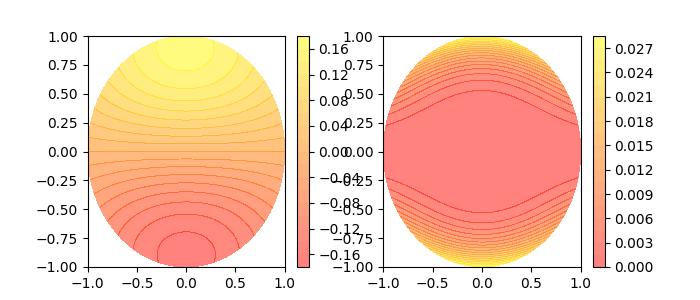

In [884]:
fig = plt.figure(figsize=(7, 3))
ax1, ax2 = fig.subplots(1, 2)
plot_sol(lambda x: sol2(x), ax1)
plot_sol(lambda x: (x[..., 2] / 3 - sol2(x)) ** 2, ax2)